In [787]:
import sympy as smp
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import pandas as pd
import csv

## Question 2, Part D

In [788]:
F = smp.symbols('F')
y = 1/3 * smp.log(0.5*F + 0.25) + 2/3 * smp.log(0.75 - 0.5*F)
derivative = smp.diff(y, F)
eq = smp.Eq(derivative, 0)
smp.solve(eq, F)

[0.166666666666667]

In [789]:
derivative

0.166666666666667/(0.5*F + 0.25) - 0.333333333333333/(0.75 - 0.5*F)

In [790]:
N, F = smp.symbols('N, F', real=True, positive=True)
p = N/3 * smp.ln(0.5*F + 0.25) + 2/3 * N * smp.ln(0.75 - 0.5*F)
p

0.666666666666667*N*log(0.75 - 0.5*F) + N*log(0.5*F + 0.25)/3

In [791]:
second_deriv = smp.diff(smp.diff(p, F), F)
second_deriv.nsimplify()

-N/(3*(F + 1/2)**2) - 8*N/(27*(1 - 2*F/3)**2)

In [792]:
second_deriv = second_deriv.subs(F, 1/6)

In [793]:
sigma = 0.05
eq2 = smp.Eq(second_deriv, -1/sigma**2)
smp.solve(eq2)

[355.555555555556]

Sub back in N = 356 trials to see whether the standard deviation checks out.

In [794]:
N, F = smp.symbols('N, F', real=True, positive=True)
p = smp.factorial(N) * (0.5 * F + 0.25)**(N/3) * (0.75 - 0.5*F)**(2*N/3) / (smp.factorial(2*N/3) * smp.factorial(N/3))
log_p = smp.log(p)
log_p

log((0.75 - 0.5*F)**(2*N/3)*(0.5*F + 0.25)**(N/3)*factorial(N)/(factorial(N/3)*factorial(2*N/3)))

In [795]:
dP = smp.diff(log_p, F)
ddP = smp.diff(dP, F)
ddP = ddP.subs(F, 1/6)

In [796]:
ddP = ddP.subs(N, 356)
ddP

-400.499999999986

In [797]:
sigma = smp.symbols('sigma', positive=True)
eq = smp.Eq(ddP, -1/sigma**2)
eq

Eq(-400.499999999986, -1/sigma**2)

In [798]:
smp.solve(eq, sigma)

[0.0499687792663908]

So the maximum likelihood estimate (the value which maximises the likelihood function y) for the coin bias F, is 1/6 or 0.1667.

## Question 3

In [799]:
df = pd.read_csv('assignmentData_Q3.csv')
df.head()

,Time,Velocity,Velocity error
0,-1.404968e+06,-0.009990,0.091479
1,1.432821e+06,0.021377,0.047274
2,2.324128e+06,0.073651,0.086443
3,7.316990e+06,0.104806,0.033608
4,6.250311e+06,0.060317,0.028153


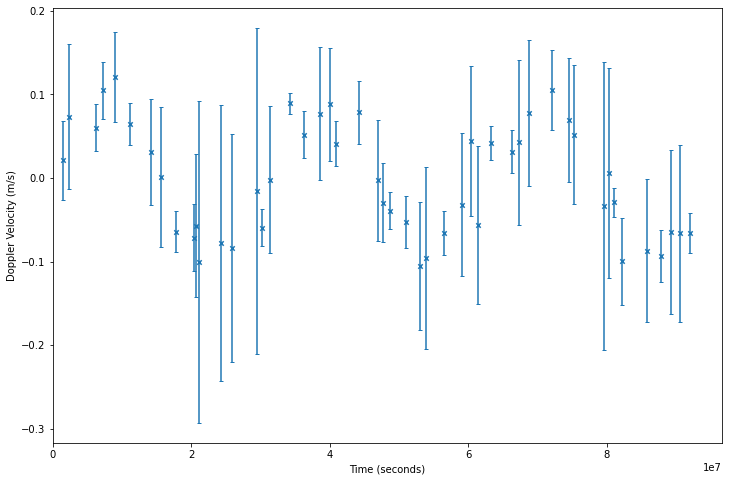

In [800]:
plt.figure(figsize=(12,8))
plt.errorbar(df['Time'], df['Velocity'], yerr=df['Velocity error'], fmt='none', capsize=2)
plt.scatter(df['Time'], df['Velocity'], s=20, marker="x")
plt.xlabel('Time (seconds)')
plt.xlim(left=0)
plt.ylabel('Doppler Velocity (m/s)')
plt.show()


In [801]:
noise = df['Velocity error']
noise = noise.to_numpy()
data = df['Velocity'].to_numpy()
x = df['Time'].to_numpy()

In [802]:
np.random.seed(332)
n_chain = int(1e4)

# sigmas for proposal distributions 
sigma_P = 0.2e6 #2e6
sigma_K = 0.0082 #0.0082

# starting values 
P_current = 4e7 # seconds
K_current = 0.3 # 0.3 m/s

proposed = K_current * np.sin(((2*np.pi)/P_current) * x)

log_like = np.sum(-(data - proposed) **2 / (2*noise**2))
chain_history = np.zeros((n_chain, 2))

accept_rate = np.zeros(n_chain)

# track the number of accepts for acceptance rate
num_of_accepts = 0
for i in range(0, n_chain):
    # select from poposal distribution
    proposed_P = P_current + sigma_P * np.random.randn()
    proposed_K = K_current + sigma_K * np.random.randn()

    # check bounds
    if proposed_K < 0 or proposed_P < 0:
        chain_history[i] = [P_current, K_current]
        continue

    # Calculate log-likelihood of proposed point
    proposed = proposed_K * np.sin(((2*np.pi)/proposed_P) * x)
    log_like_proposed =  np.sum(-(data - proposed) **2 / (2*noise**2))

    # compare to current location
    relprob = np.exp(log_like_proposed-log_like)

    # Decide whether to step
    randval = np.random.random()
    if randval < relprob: # Condition to accept step
        P_current = proposed_P
        K_current = proposed_K
        log_like = log_like_proposed
        num_of_accepts += 1
    
    # Record current position
    chain_history[i] = [P_current, K_current]
    accept_rate[i] = num_of_accepts/(i+1)


In [803]:
np.mean(accept_rate)

0.4428179510179886

With these proposal distributions, we obtain an average acceptance rate of approximately 44%.

## Part (B) Scatter Plot of MCMC

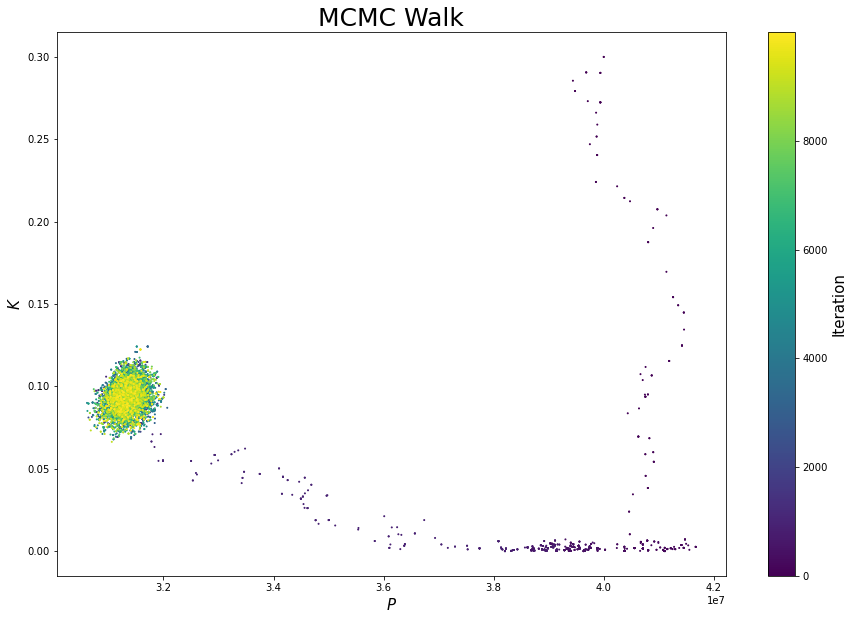

In [804]:
plt.figure(figsize=(15, 10))
plt.scatter(chain_history[:,0], chain_history[:,1], s=1, c=np.arange(0, n_chain), cmap='viridis')
plt.colorbar().ax.set_ylabel('Iteration', fontsize=15)
plt.title('MCMC Walk', fontsize=25)
plt.xlabel('$P$', fontsize=15)
plt.ylabel('$K$', fontsize=15)
plt.savefig('scatter_MCMC_fullChain.png')
plt.show()

Closer look at the distribution after burn-in. 

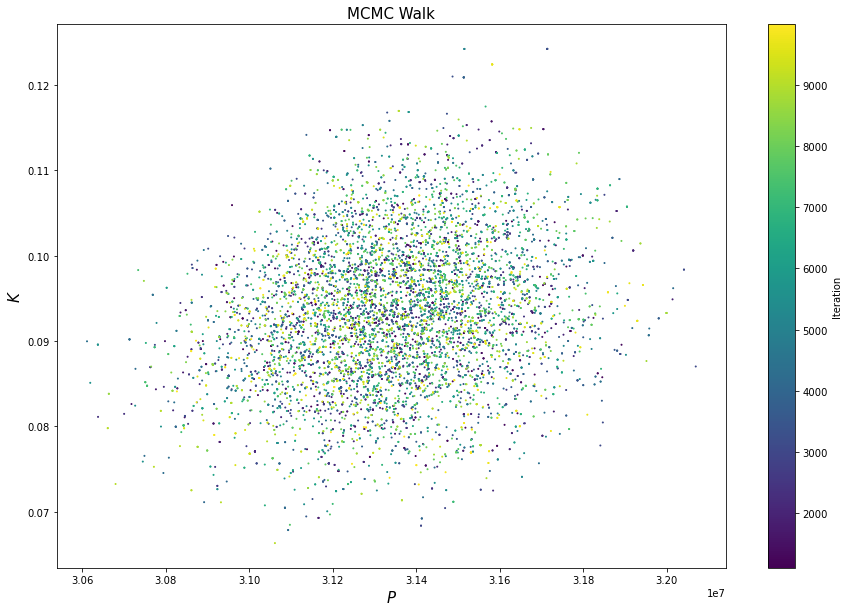

In [805]:
plt.figure(figsize=(15, 10))
plt.scatter(chain_history[1100:,0], chain_history[1100:,1], s=1, c=np.arange(1100, n_chain), cmap='viridis')
plt.colorbar().ax.set_ylabel('Iteration')
plt.title('MCMC Walk', fontsize=15)
plt.xlabel('$P$', fontsize=15)
plt.ylabel('$K$', fontsize=15)
plt.show()

## Part (C) Examine the burn-in

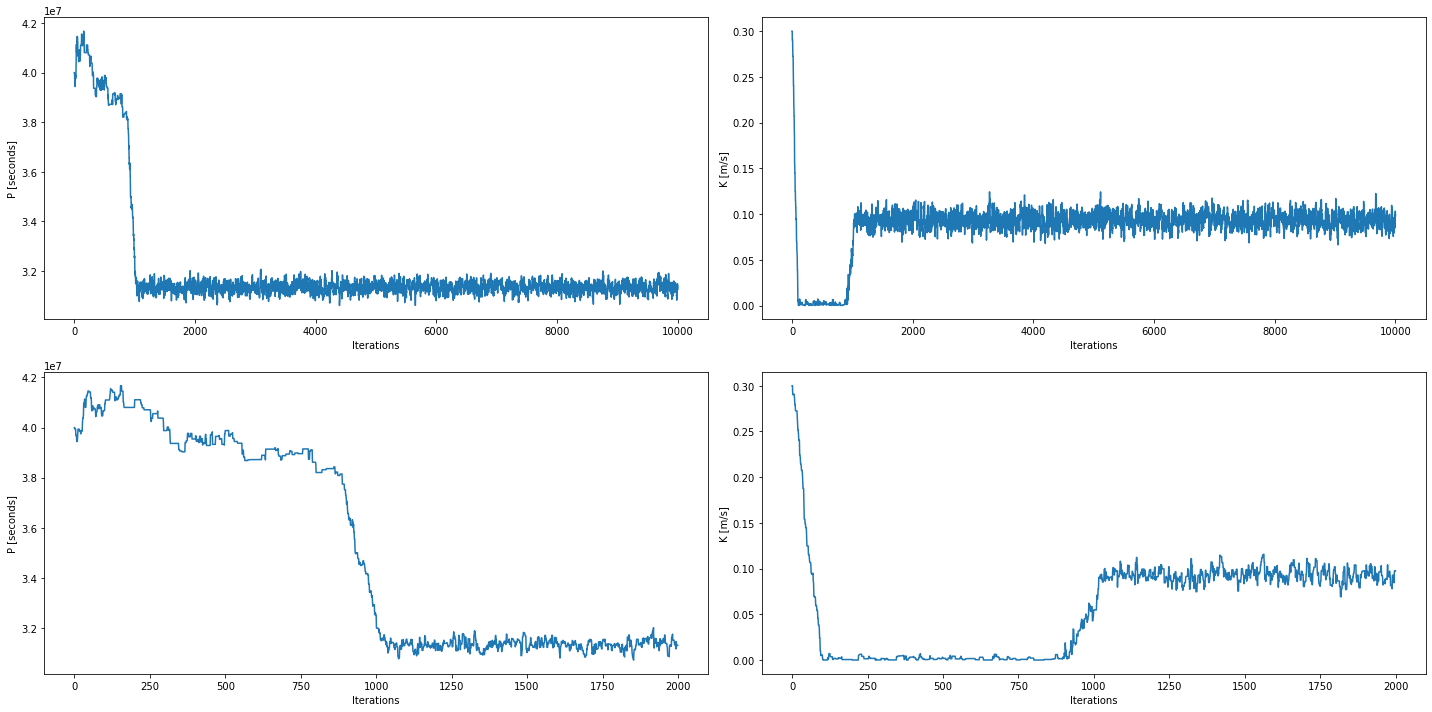

In [806]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].plot(chain_history[:,0])
ax[0,0].set_xlabel('Iterations')
ax[0,0].set_ylabel('P [seconds]')
ax[0,1].plot(chain_history[:,1])
ax[0,1].set_xlabel('Iterations')
ax[0,1].set_ylabel('K [m/s]')
ax[1,0].plot(chain_history[:2000,0])
ax[1,0].set_xlabel('Iterations')
ax[1,0].set_ylabel('P [seconds]')
ax[1,1].plot(chain_history[:2000,1])
ax[1,1].set_xlabel('Iterations')
ax[1,1].set_ylabel('K [m/s]')
plt.tight_layout()
plt.show()

The burn-in appears to last for approximately 1100 iterations. We will truncate here.

In [807]:
chain = chain_history[1100:, :] # truncate 

## Part (D) Marginal Posteriors for P and K 

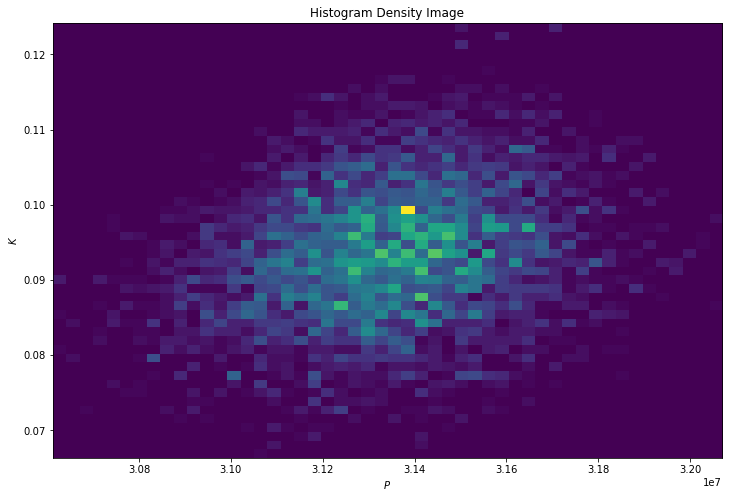

In [808]:
bins = 50
heatmap, x_edges, y_edges = np.histogram2d(chain[:,0], chain[:,1], bins=bins)
heatmap /= len(chain)
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
x_vals = [(x_edges[i] + x_edges[i+1]) / 2 for i in range(bins)]
y_vals = [(y_edges[i] + y_edges[i+1]) / 2 for i in range(bins)]
plt.figure(figsize=(12,8))
plt.imshow(np.rot90(heatmap), extent=extent, aspect='auto')
plt.xlabel('$P$')
plt.ylabel('$K$')
plt.title('Histogram Density Image')
plt.show()

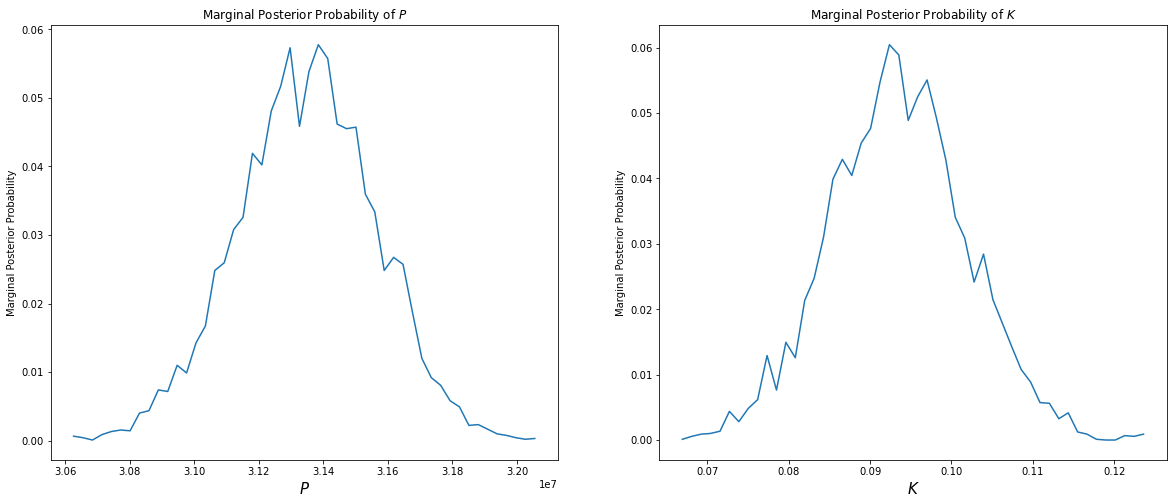

In [809]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(x_vals, heatmap.sum(axis=1))
ax[0].set_xlabel('$P$', fontsize=15)
ax[0].set_ylabel('Marginal Posterior Probability')
ax[0].set_title('Marginal Posterior Probability of $P$')
ax[1].plot(y_vals, heatmap.sum(axis=0))
ax[1].set_xlabel('$K$', fontsize=15)
ax[1].set_ylabel('Marginal Posterior Probability')
ax[1].set_title('Marginal Posterior Probability of $K$')
plt.show()

Estimates of the most likely values for $P$ and $K$ using the mode of their respective distributions:

In [810]:
def expected_value(values, probabilities):
    return sum([v * p for v, p in zip(values, probabilities)])
print('Expected Value P: {:.3e}'.format(expected_value(x_vals, heatmap.sum(axis=1))))
print('Expected Value K: {:.5f}'.format(expected_value(y_vals, heatmap.sum(axis=0))))


Expected Value P: 3.135e+07
Expected Value K: 0.09349


In [811]:
mode_index_P = np.argmax(heatmap.sum(axis=1))
mode_index_K = np.argmax(heatmap.sum(axis=0))
most_likely_P = x_vals[mode_index_P]
most_likely_K = y_vals[mode_index_K]
print('Mode P = {:.3e}'.format(most_likely_P))
print('Mode K = {:.4f}'.format(most_likely_K))


Mode P = 3.138e+07
Mode K = 0.0924


In [812]:
most_likely_K = expected_value(y_vals, heatmap.sum(axis=0))
most_likely_P = expected_value(x_vals, heatmap.sum(axis=1))

In [813]:
most_likely_P

31347106.76826941

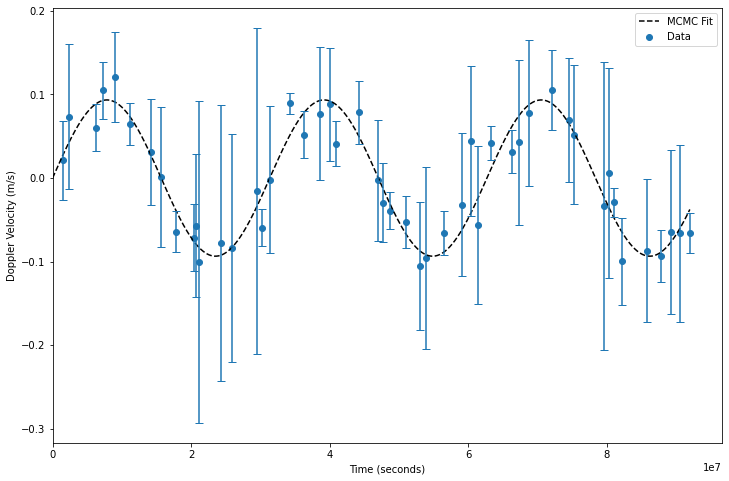

In [814]:
plt.figure(figsize=(12,8))
x_vals = np.linspace(0, np.max(x), 10000)
plt.plot(x_vals, most_likely_K * np.sin(((2*np.pi)/most_likely_P) * x_vals), color='k', linestyle = '--', label='MCMC Fit')
plt.scatter(df['Time'], df['Velocity'], label='Data')
plt.errorbar(df['Time'], df['Velocity'], yerr=df['Velocity error'], fmt='none', capsize=4)
plt.legend()
plt.xlabel('Time (seconds)')
plt.xlim(left=0)
plt.ylabel('Doppler Velocity (m/s)')
plt.show()

## Part E

In [817]:
P = most_likely_P
G = 6.6743e-11 # m^3 kg^-1 s^-2
M_star = 2*10**30 # kg
r = (((G * M_star) / (4 * np.pi**2)) * P**2)**(1/3)
r_km = r/1e3
print('Orbital Radius: %.2e km' % r_km)
if r_km > 8e7 and r_km < 3e8:
    print('Planet lies within habitable zone')
else:
    print('Planet does not lie within habitable zone')

Orbital Radius: 1.49e+08 km
Planet lies within habitable zone


## Part F

In [816]:
K = most_likely_K
V_star = K/np.sin(np.pi/2) # m/s
V_planet = np.sqrt((G*M_star)/r) # m/s
M_planet = M_star * V_star / V_planet
print('Mass of Material: %.2e kg' % M_planet)

Mass of Material: 6.25e+24 kg
